In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
    QuantileTransformer
)

from src.config import DADOS_CATEGORIZADOS
from src.modelos import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao
)

sns.set_theme(palette='bright')

RANDOM_STATE = 42

In [2]:
df = pd.read_parquet(DADOS_CATEGORIZADOS)

df.head()

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,triglicerides,glicose,target,colesterol_hdl_cat
0,59,2,32.099998,101.0,157,93.199997,38.0,4.8598,87,151,4-5
1,48,1,21.600000,87.0,183,103.199997,70.0,3.8918,69,75,2-3
2,72,2,30.500000,93.0,156,93.599998,41.0,4.6728,85,141,4-5
3,24,1,25.299999,84.0,198,131.399994,40.0,4.8903,89,206,4-5
4,50,1,23.000000,101.0,192,125.400002,52.0,4.2905,80,135,4-5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int8    
 1   sexo                442 non-null    int8    
 2   imc                 442 non-null    float32 
 3   pressao_media       442 non-null    float32 
 4   colesterol_total    442 non-null    int16   
 5   ldl                 442 non-null    float32 
 6   hdl                 442 non-null    float32 
 7   triglicerides       442 non-null    float32 
 8   glicose             442 non-null    int8    
 9   target              442 non-null    int16   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float32(5), int16(2), int8(3)
memory usage: 12.3 KB


In [4]:
X = df.drop(columns='target')
y = df['target']

In [5]:
colunas_power_transform = ['imc', 'ldl', 'hdl', 'colesterol_total']

coluna_target = ['target']

coluna_ordinal_encoder = ['colesterol_hdl_cat']

coluna_one_hot_encoder = ['sexo']

colunas_standard_scaler = [
    coluna for coluna in df.columns
        if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

colunas_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [6]:
categorias_ordinal_encoder = [
    ['2-3', '4-5', '6+']
]

In [7]:
preprocessamento_categoricas = ColumnTransformer(
    transformers = [
        ('ordinal_encoder', OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ('one_hot_encoder', OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder)
    ],
    remainder='passthrough'
)

preprocessamento_simples = ColumnTransformer(
    transformers = [
        ('ordinal_encoder', OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ('one_hot_encoder', OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder),
        ('standard_scaler', StandardScaler(), X.columns.difference(coluna_ordinal_encoder + coluna_one_hot_encoder))
    ],
    remainder='passthrough'
)

preprocessamento_completo = ColumnTransformer(
    [
        ('power_transform', PowerTransformer(method='box-cox'), colunas_power_transform),
        ('standard_scaler', StandardScaler(), colunas_standard_scaler),
        ('ordinal_encoder', OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ('one_hot_encoder', OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder)
    ]
)

In [8]:
target_transformer = QuantileTransformer(n_quantiles=20, output_distribution='normal')

In [9]:
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None
    },
    'LinearRegression_pre_cat': {
        'preprocessor': preprocessamento_categoricas,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    'LinearRegression_pre_simples': {
        'preprocessor': preprocessamento_simples,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    'LinearRegression_pre_completo': {
        'preprocessor': preprocessamento_completo,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    'LinearRegression_pre_completo_target': {
        'preprocessor': preprocessamento_completo,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer
    },
}

In [10]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

In [11]:
resultados

{'DummyRegressor': {'fit_time': array([0.00626683, 0.00250602, 0.00100446, 0.0010016 , 0.00151062]),
  'score_time': array([0.00616002, 0.00100565, 0.01252103, 0.00251389, 0.00200152]),
  'test_r2': array([-0.01196298, -0.02697753, -0.01530397, -0.00021233, -0.04231598]),
  'test_neg_mean_absolute_error': array([-64.00646147, -70.57793551, -59.82954545, -70.05392912,
         -65.42565485]),
  'test_neg_root_mean_squared_error': array([-73.22249284, -80.04318688, -74.33859714, -82.04745226,
         -76.3152967 ])},
 'LinearRegression_pre_cat': {'fit_time': array([0.33721638, 0.01447296, 0.01308513, 0.01052833, 0.01384425]),
  'score_time': array([0.01534104, 0.01028466, 0.00902915, 0.00929093, 0.00894403]),
  'test_r2': array([0.45229974, 0.57370343, 0.40683322, 0.58812556, 0.39131906]),
  'test_neg_mean_absolute_error': array([-42.98079793, -41.53071359, -46.70245311, -41.89567184,
         -47.42385671]),
  'test_neg_root_mean_squared_error': array([-53.8683498 , -51.57031956, -56.8

In [12]:
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.006267,0.00616,-0.011963,-64.006461,-73.222493,0.012427
1,DummyRegressor,0.002506,0.001006,-0.026978,-70.577936,-80.043187,0.003512
2,DummyRegressor,0.001004,0.012521,-0.015304,-59.829545,-74.338597,0.013525
3,DummyRegressor,0.001002,0.002514,-0.000212,-70.053929,-82.047452,0.003515
4,DummyRegressor,0.001511,0.002002,-0.042316,-65.425655,-76.315297,0.003512
5,LinearRegression_pre_cat,0.337216,0.015341,0.4523,-42.980798,-53.86835,0.352557
6,LinearRegression_pre_cat,0.014473,0.010285,0.573703,-41.530714,-51.57032,0.024758
7,LinearRegression_pre_cat,0.013085,0.009029,0.406833,-46.702453,-56.820458,0.022114
8,LinearRegression_pre_cat,0.010528,0.009291,0.588126,-41.895672,-52.650369,0.019819
9,LinearRegression_pre_cat,0.013844,0.008944,0.391319,-47.423857,-58.318555,0.022788


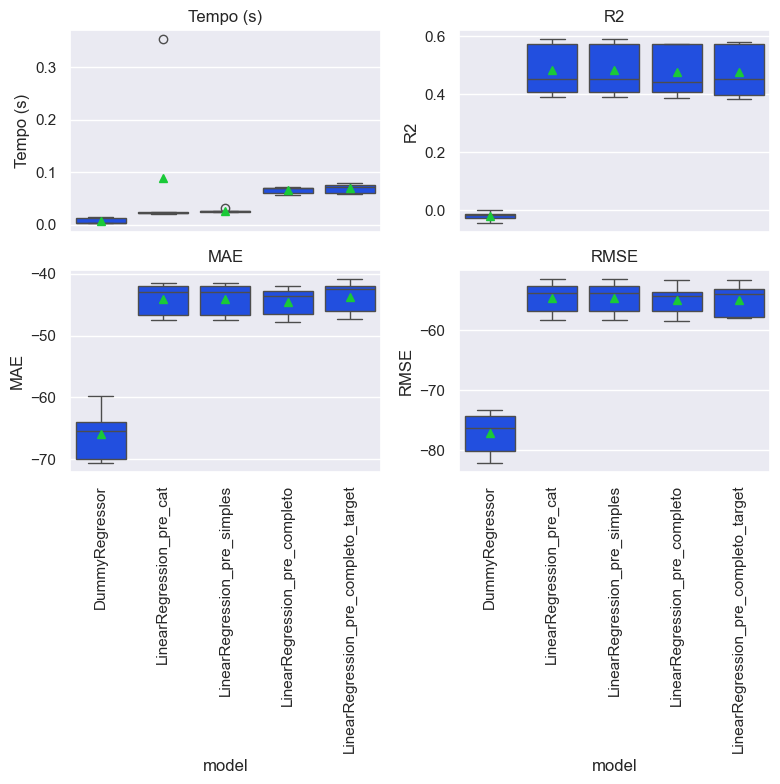

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

comparar_metricas = [
    'time_seconds',
    'test_r2',
    'test_neg_mean_absolute_error',
    'test_neg_root_mean_squared_error'
]

nomes_metricas = [
    'Tempo (s)',
    'R2',
    'MAE',
    'RMSE'
]

for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):
    sns.boxplot(
        x='model',
        y=metrica,
        data=df_resultados,
        ax=ax,
        showmeans=True
    )
    ax.set_title(nome)
    ax.set_ylabel(nome)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()